Translation of VAE chapter to pytorch

In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Pad(2, 0.0)])
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

/Users/xqiu/Code/GenDL/.venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

## visualize data

Sandal  Shirt  Trouser  T-shirt/top


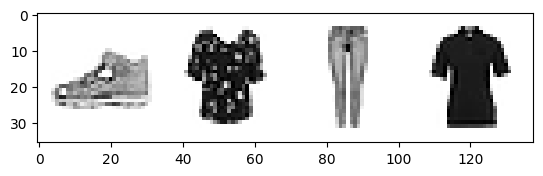

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

## build model

In [44]:
import torch.nn as nn
import torch.nn.functional as F

# Encoder
# PyTorch models inherit from torch.nn.Module
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            # 32x32 in, 16x16 out
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # 16x16 in, 8x8 out
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # 8x8 in, 4x4 out
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # shape before flattening is [128, 4, 4]
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 2),
        )  
        shape_before_flattening = (128, 4, 4)
        self.decoder = nn.Sequential(
            nn.Linear(2, np.prod(shape_before_flattening)),
            nn.Unflatten(1, shape_before_flattening),
            # 4x4 -> 8x8
            nn.ConvTranspose2d(128, 128, stride=2, kernel_size=3, padding=1, output_padding=1),
            nn.ReLU(),
            # 8x8 -> 16x16
            nn.ConvTranspose2d(128, 64, stride=2, kernel_size=3, padding=1, output_padding=1),
            nn.ReLU(),
            # 16x16 -> 32x32
            nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1, output_padding=1),
            nn.ReLU(),
            # reduce output dims to 1
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
            nn.Sigmoid(),  # to map between 0 & 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    '''
    test = encoded
    for m in self.decoder.children():
            test = m(test)
            print(test.shape)
    '''

In [46]:
model = AutoEncoder()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
batch_size = 100
# Reinit data loaders for our datasets
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)


In [50]:
for epoch in range(epochs):
    batch_num = 0
    for (img, _) in training_loader:
        recovered = model(img)
        loss = loss_fn(recovered, img)

        optimizer.zero_grad() # reset gradients
        loss.backward()
        optimizer.step()
        if batch_num % 100 == 99:
            print(f"Batch {batch_num}")
        batch_num += 1
    print(f'Epoch:{epoch}, Loss:{loss.item():.4f}')


Batch 99
Batch 199
Batch 299
Batch 399
Batch 499
Batch 599
Epoch:0, Loss:0.2577
Batch 99
Batch 199
Batch 299
Batch 399
Batch 499
Batch 599
Epoch:1, Loss:0.2392
Batch 99
Batch 199
Batch 299
Batch 399
Batch 499
Batch 599
Epoch:2, Loss:0.2495
Batch 99
Batch 199
Batch 299
Batch 399
Batch 499
Batch 599
Epoch:3, Loss:0.2497
Batch 99
Batch 199
Batch 299
Batch 399
Batch 499
Batch 599
Epoch:4, Loss:0.2671


In [51]:
# save model
save_path = "basic_ae"
torch.save(model.state_dict(), save_path)

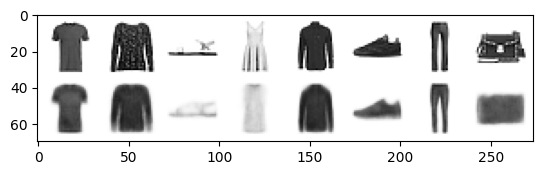

In [77]:
# apply model
model.eval()
# original
im_batch, label_batch = next(iter(validation_loader))
# encode/decode
im_recovered = model(im_batch)

# view images
start_idx = 88
how_many = 8
imgs = torch.cat((im_batch[start_idx:start_idx+how_many], 
                  im_recovered[start_idx:start_idx+how_many]))
img_grid = torchvision.utils.make_grid(
    imgs,
    nrow=how_many)
matplotlib_imshow(img_grid, one_channel=True)